# Исследовательский и статистический анализ данных сервиса аренда самокатов.

В нашем распоряжении следующие данные сервиса аренды самокатов:

**Датафрейм 1:**
- `user_id` - уникальный идентификатор пользователя
- `name` - имя пользователя
- `age` - возраст
- `city` - город
- `subscription_type` - тип подписки (free, ultra)

**Датафрейм 2:**
- `user_id` - уникальный идентификатор пользователя
- `distance` -	расстояние, которое пользователь проехал в текущей сессии (в метрах)
- `duration` -	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- `date` -	дата совершения поездки

**Датафрейм 3:**
- `subscription_type`	тип подписки
- `minute_price` -	стоимость одной минуты поездки по данной подписке
- `start_ride_price` -	стоимость начала поездки
- `subscription_fee` -	стоимость ежемесячного платежа

Рассмторим их и проведем предобработку данных.

In [1]:
import pandas as pd
import matplotlib as plt
import numpy as np
from scipy import stats as st
from scipy.stats import binom, norm
from matplotlib import pyplot as plt
from math import sqrt

## Шаг 1. Загрузка данных 
<a id='download'></a>

In [2]:

try:
    data_users = pd.read_csv('')
    data_rides = pd.read_csv('', parse_dates=['date'])
    data_sub = pd.read_csv('')
except:
    data_users = pd.read_csv('users_go.csv')
    data_rides = pd.read_csv('rides_go.csv')
    data_sub = pd.read_csv('subscriptions_go.csv')
    print('Произошел сбой внешней загрузки!')

Предварительно оценим датафреймы и информацию в них.

In [3]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [4]:
data_users.head(10)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


In [5]:
data_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


In [6]:
data_rides.head(10)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


In [7]:
data_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


In [8]:
data_sub.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


После первого рассмотрения данных стоит выделить основные моменты:

В датафрейме с информацией о пользователях 1565 строк, то есть дана информация о 1565 пользователях, однако, необходимо проверить датафрейм на дубликаты. В этом датафрейме для данных указаны подходящие типы данных, дополнительных действий с ним не требуется.

В датафрейме с информацией о поездках 18068 строк. Эти данные также требуется проверить на наличие дубликатов. Изначально столбец, содержащий дату поездки был представлен в формат object, однако на этапе загрузки данных мы перевели его в корректный формат даты. Также информация о длительности поездки и расстоянии даны с точностью 6 знаков после запятой, такая точность в целом излишне, но пока оставим данные в исходном виде и округлим их в случае необходимости.

Датафрейм с информацией о подписках содержит всего 2 строки. Одна строка с информацией о цене старта, цене за минуту и плате за подписку для владельцев подписки, а вторая - с аналогичной информацией для пользователей без подписки.

## Шаг 2. Предобработка данных
<a id='preproc'></a>

### 2.1 Преобразование столбцов к подоходящему типу данных.

В результате первичной оценки данных, установлено, что единственный столбец, требующий преобразования типа данных - это столбец `date` датафрейма `data_rides`. Однако мы преобразовали его на этапе загрузки данных.

### 2.2 Добавление новых столбцов.

Добавим в датафрейм `data_rides` столбец `ride_month`, содержащий информацию о порядковом номере месяца, в котором была совершена поездка.

In [9]:
# Создадим столбец содержащий порядковый номер месяца с помощью метода dt.month
data_rides['ride_month'] = data_rides['date'].dt.month
# Посмотрим результат
data_rides['ride_month']

0         1
1         1
2         4
3         8
4         8
         ..
18063    11
18064    11
18065    11
18066    11
18067    12
Name: ride_month, Length: 18068, dtype: int64

In [10]:
min(data_rides['date'])

Timestamp('2021-01-01 00:00:00')

In [11]:
max(data_rides['date'])

Timestamp('2021-12-30 00:00:00')

В нашем распоряжении данные за 2021 год.

<div style>
<font size="4"><b></b></font>
<font size="5", color = "black">
👍

### 2.3 Проверка на наличие пропусков.

In [12]:
data_users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [13]:
data_rides.isna().sum()

user_id       0
distance      0
duration      0
date          0
ride_month    0
dtype: int64

In [14]:
data_sub.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Во всех трёх датафреймах отсутствуют пропуски.

### 2.4 Проверка на наличие дубликатов.

In [15]:
# Применем метод duplicated, а затем посчитаем с помощью метода sum количество дубликатов.
data_users.duplicated().sum()

31

In [16]:
data_users.shape

(1565, 5)

Найден 31 дубликат. Удалим их.

In [17]:
# Удалим дубликаты и обновим индексы датафрейма.
data_users = data_users.drop_duplicates().reset_index(drop=True)

In [18]:
data_users.shape

(1534, 5)

In [19]:
data_rides.duplicated().sum()

0

Проверять датафрейм `data_sub` на наличие дубликатов не имеет смысла.

На этапе предобработки данных проведены следующие действия:

* Столбец `date` датафрейма `data_rides` переведен в формат `datetime`
* В датафрейм `data_rides` добавлен столбец `ride_month`, содержащий информацию о порядковом номере месяца, в котором была совершена поездка
* Проведена проверка на наличие пропусков. Пропускм отсутствуют.
* Проведена проверка на наличие дубликатов. Обнаружены и удалены 31 дубликат в столбце `data_users`

## Шаг 3. Исследовательский анализ данных
<a id='data_analysis'></a>

### 3.1 Частота встречаемости городов.

In [20]:
data_users.value_counts('city')

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
dtype: int64

In [21]:
data_users.value_counts('city').describe()

count      8.000000
mean     191.750000
std       15.672998
min      168.000000
25%      182.250000
50%      191.000000
75%      199.500000
max      219.000000
dtype: float64

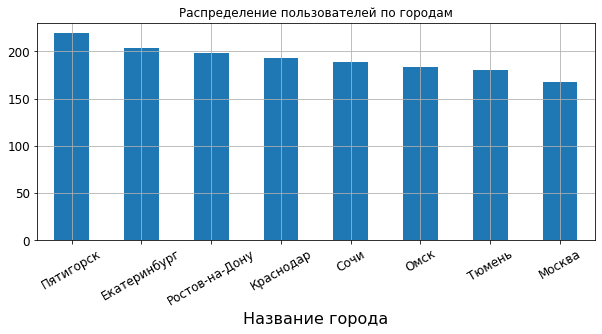

In [22]:
data_users.value_counts('city').plot.bar(rot=30,title='Распределение пользователей по городам',\
grid=True, figsize=(10,4), fontsize=12)\
.set_xlabel('Название города', fontsize=16);

In [23]:
(data_users.value_counts('city')/data_users.value_counts('city').sum()*100).round(2)

city
Пятигорск         14.28
Екатеринбург      13.30
Ростов-на-Дону    12.91
Краснодар         12.58
Сочи              12.32
Омск              11.93
Тюмень            11.73
Москва            10.95
dtype: float64

Как мы видим по таблице частот, общему описанию, а также столбчатой диаграмме в датафрейме представлены пользователи из 8 городов. Больше всего пользователей в Пятигорске - **219**, а меньше всего в Москве - **168**. Если рассматривать в процентах, то разница между самым популярным и самым непопулярным городом составляет чуть менее **2.5%**. Это не слишком много, но учитывая, что самый непопулярный город - это Москва, то стоит обратить внимание на потенциал развития в данном мегаполисе.

### 3.2 Соотношение пользователей с подпиской и без подписки

In [24]:
subscription_users = data_users.pivot_table(index='subscription_type', values='user_id',aggfunc='count')
subscription_users

,user_id
subscription_type,
free,835
ultra,699


In [25]:
subscription_users['proportion'] = subscription_users['user_id']/len(data_users)
subscription_users

,user_id,proportion
subscription_type,,
free,835,0.544329
ultra,699,0.455671


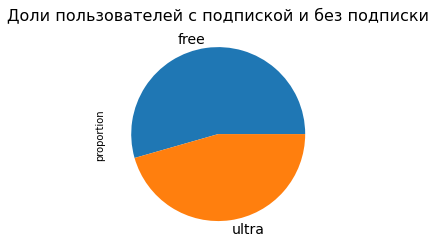

In [26]:
subscription_users['proportion'].plot.pie(xlabel='Тип подписки', grid=True, rot=0, fontsize=14)\
.set_title('Доли пользователей с подпиской и без подписки', fontsize=16);

Доля пользователей приложения, не имеющих подписку, больше примерно на 9% (54,5% пользователей без подписки и 45,5% пользователей с подпиской).

### 3.3 Возраст пользователей.

In [27]:
data_users.pivot_table(index='age', values='user_id', aggfunc='count')

,user_id
age,
12,4
13,8
14,9
15,13
16,19
17,26
18,46
19,47
20,71


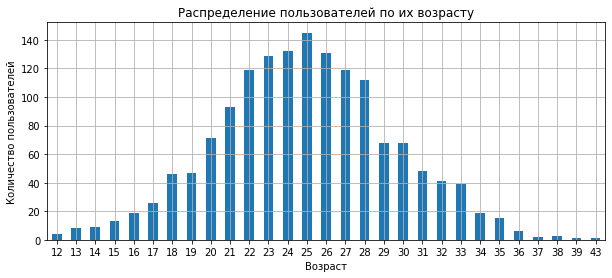

In [28]:
data_users.pivot_table(index='age', values='user_id', aggfunc='count')\
.plot.bar(
legend=False,
rot=0, 
figsize=(10,4), 
xlabel='Возраст', 
ylabel='Количество пользователей',
title='Распределение пользователей по их возрасту',
grid=True);

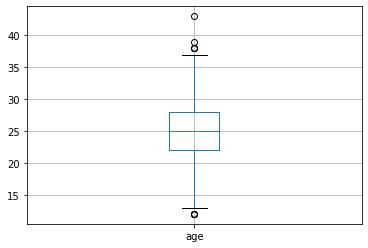

In [29]:
data_users.boxplot('age');

In [30]:
data_users['age'].quantile([0.25,0.75])

0.25    22.0
0.75    28.0
Name: age, dtype: float64

In [31]:
22 - (28 - 22) * 1.5

13.0

In [32]:
28 + (28 - 22) * 1.5

37.0

Возраст меньше 13 и больше 37 лет можно признать выбросами.

In [33]:
data_users.query('age < 13 or age > 37')['age'].count()/data_users['age'].count()*100

0.5867014341590613

выбросы составляют менее 1% от общего объема данных по возрасту.

Можно наблюдать, что график распределения пользователей приложения по возрасту соответствует графику нормального распределения с центром распределения в районе 25 лет. Пользователи приложения расположены в диапазоне от 12 до 43 лет. Также можно заметить, что данный график имеет больше аномальных значений справа - то есть для более возрастных пользователей. Вероятно, это объясняется тем, что сервис недоступен для детей младше 12 лет.

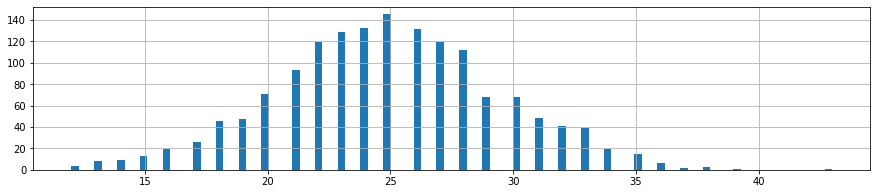

In [34]:
data_users.age.hist(bins=100, figsize=(15,3));

In [35]:
data_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     18068 non-null  int64         
 1   distance    18068 non-null  float64       
 2   duration    18068 non-null  float64       
 3   date        18068 non-null  datetime64[ns]
 4   ride_month  18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB


### 3.4 Расстояние, которое пользователь преодолел за одну поездку

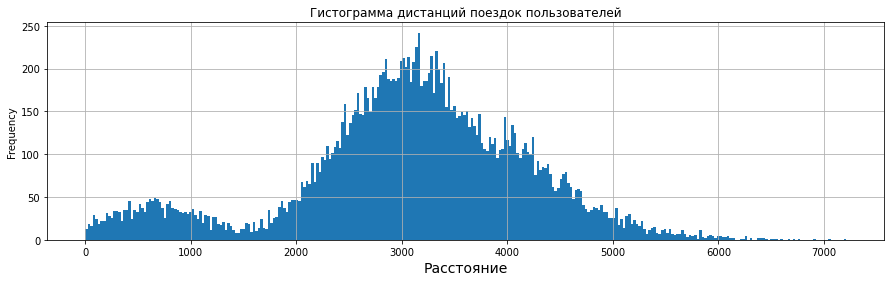

In [36]:
data_rides['distance'].plot.hist(
bins=300,
figsize=(15,4),
grid=True,
title='Гистограмма дистанций поездок пользователей',
legend=False)\
.set_xlabel('Расстояние', fontsize=14);

По гистограмме мы видим, что основное количество поездое имелю длину в районе 3000 метров. Однако присутствуют выбросы, значительно отличающиеся, как в большую, так и в меньшую сторону. Так как задачи отбросить выбросы не стоит, то оставим эти значения. На графике заметны два пика: большой в районе 3100 метров и малый в районе 700 метров. Можно предположить, что пик в районе 3100 метров вызван тем, что это расстояние, для преодоления которого люди с наибольшей вероятностью воспользуются арендой самоката, так как меньшее расстояние можно пройти пешком, а чтобы преодолеть большее расстояние, целесообразнее уже заказать такси/поехать на общественном транспорте.

Пик в районе 700 метров - это скорее всего первые пробные поездки.

In [37]:
data_rides['distance'].mean().round(0)

3071.0

Среднее расстояние поездок равно **3071 метр**.

Посмотрим на выбросные значения.

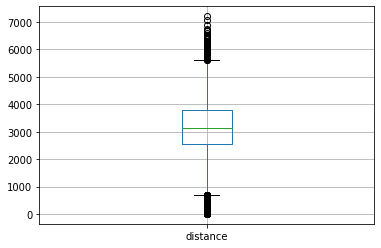

In [38]:
data_rides.boxplot('distance');

In [39]:
data_rides['distance'].quantile([0.25, 0.75]).round(0)

0.25    2543.0
0.75    3776.0
Name: distance, dtype: float64

In [40]:
2543 - (3776 - 2543) * 1.5

693.5

In [41]:
3776 + (3776 - 2543) * 1.5

5625.5

In [42]:
data_rides.query('distance < 693.5 or distance > 5625.5')['distance'].count()/data_rides['distance'].count()

0.05733894177551472

Слишком большой процент потерь. Попробуем отсечь 1% выбросов иным способом.

In [43]:
data_rides['distance'].quantile([0.005, 0.995]).round()

0.005     110.0
0.995    5749.0
Name: distance, dtype: float64

In [44]:
data_rides.query('distance < 110.3 or distance > 5749.3')['distance'].count()/data_rides['distance'].count()

0.01012840380783706

Поездки длительностью меньше 110 и более 5749 метров можно признать выбросами. Гистограмма также подтверждает, что поездок длиннее ~ 5750 практически нет, поездок короче 110 метров также очень мало.

### 3.5 Продолжительность поездок.

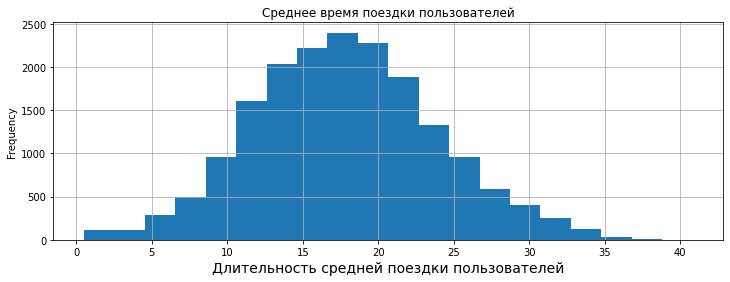

In [45]:
data_rides['duration'].plot.hist(
bins=20, 
figsize=(12,4),
title='Среднее время поездки пользователей',
grid=True)\
.set_xlabel('Длительность средней поездки пользователей', fontsize=14);

In [46]:
data_rides['duration'].mean().round(1)

17.8

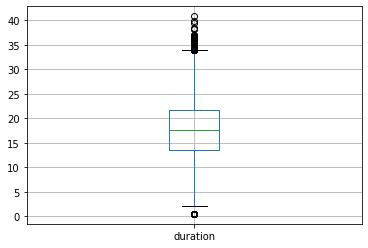

In [47]:
data_rides.boxplot('duration');

Бросается в глаза, что большинство выбросов присутствует "сверху".

In [48]:
data_rides['duration'].quantile([0.25, 0.75]).round(1)

0.25    13.6
0.75    21.7
Name: duration, dtype: float64

In [49]:
13.6 - (21.7 - 13.6) * 1.5

1.450000000000001

In [50]:
21.7 + (21.7 - 13.6) * 1.5

33.849999999999994

In [51]:
data_rides.query('duration < 1.45 or duration > 33.8')['duration'].count()/data_rides['duration'].count()

0.010183750276732344

Поездки короче полутора и длиннее ~ 34 минут можно признать выбросами.

На этапе исследовательского анализа данных нами проведены следующие действия:

* Проведена оценка встречаемости городов, в которых брали в аренду самокаты. Всего 8 городов. Больше всего пользователей в Пятигорске - **219**, а меньше всего в Москве - **168**. В процентах это около 2.5% разницы. Однако самый непопулярный город - Москва, имеющий огромный потенциал для развития. Стоит обратить внимание на этот город и провести рекламную акцию для москвичей, а также подумать над расширением бизнеса там.
* Определено соотношение пользователей с подпиской и без подписки. Соотношение равно 54.4% пользователей без подписки и 46.6% пользователей с подпиской.
* Определен возраст пользователей. Сервисом пользуются люди **от 12 до 43 лет**, также можно обратить внимание, что возраст распределяется нормально, что говорит о хорошем качестве данных. Значения меньше 13 и больше 37 лет признаны выбросами, однако оставлены для дальнейшего исследования. Пик приходится на 25 лет. Следует разрабатывать рекламные акции, а также тарифы с расчетом на целевую аудиторию в диапазоне 20 - 30 лет. Например: скидки для студентов, размещение парковок самокатов около университетов и так далее.
* Оценено расстояние, которое пользователи преодолевают за поездку. Среднее расстояние равно **3071 метр** за поездку. Большая часть поездок имеют расстояние **от 2000 до 5000 метров**. поездки **короче 110 и длиннее 5750 метров** признаны выбросами. На графике заметны два пика: большой в районе **3100 метров** и малый в районе **700 метров**. Можно предположить, что пик в районе 3100 метров вызван тем, что это расстояние, для преодоления которого люди с наибольшей вероятностью воспользуются арендой самоката, так как меньшее расстояние можно пройти пешком, а чтобы преодолеть большее расстояние, целесообразнее уже заказать такси/поехать на общественном транспорте. Исходя из этого предположения стоит рассмтотреть возможность размещения самокатов там, где люди с большей вероятностью возьмут самокат не с целью добраться до какой-либо точки, а чтобы просто покататься, например у входов в парки. Пик в районе 700 метров - это скорее всего первые пробные поездки. В таком случае требуется сделать эти пробные метры наиболее привлекательными, например первые 1000 метров будут стоить дешевле или вообще бесплатными.
* Оценена продолжительность поездок. Средняя продолжительность поездки составила около **18 минут**. Длительность поездок не превышает **40 минут**. Определено, что поездки **короче 1.5 и длиннее 34 минут** являются выбросами. Стоит рассмотреть возможность ограничения скорости самокатов в пешеходных зонах, парках и например в радиусе 300 метров от школ, детских садов, с одной стороны это повысит безопасность, а с другой увеличит время, за которое человек сможет преодолеть необходимое емк расстояние, что повысит выручку.

## Шаг 4. Объединение данных
<a id='join'></a>

### 4.1 Создание единого датафрейма.

In [52]:
data_users.shape

(1534, 5)

In [53]:
data_rides.shape

(18068, 5)

In [54]:
data_total = data_users.merge(data_rides,on='user_id')
data_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   ride_month         18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 1.4+ MB


In [55]:
data_total.shape

(18068, 9)

Сравнение количества строк до и после объединения показывает, что объединение датафреймов прошло успешно, строки не потеряны.
В результате мы получили объкдиненный датафрейм, в котором хранится информация об id пользователя, его имени, возрасте, городе, наличии/отсутствии подписки, а также сведения о расстоянии и длительности его поездок, дате совершения поездок и порядковом номере месяца, когда была совершена поездка.

### 4.2 Создание датафреймой с информацией о пользователях с подпиской и без подписки.

In [56]:
data_ultra = data_total[data_total['subscription_type'] == 'ultra']
data_ultra

,user_id,name,age,city,subscription_type,distance,duration,date,ride_month
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8
...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,ultra,3973.046497,24.671163,2021-08-29,8
6496,699,Оксана,22,Москва,ultra,3288.702563,15.892886,2021-09-12,9
6497,699,Оксана,22,Москва,ultra,3076.159348,14.389525,2021-09-26,9
6498,699,Оксана,22,Москва,ultra,4707.845501,15.839579,2021-10-17,10


In [57]:
data_non_ultra = data_total[data_total['subscription_type'] != 'ultra']
data_non_ultra

,user_id,name,age,city,subscription_type,distance,duration,date,ride_month
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2
...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11


In [58]:
if len(data_ultra) + len(data_non_ultra) == len(data_total):
    print('Количество потерянных строк равно 0, всё сошлось.')
else:
    print('Возникла ошибка, количество строк не сходится.')

Количество потерянных строк равно 0, всё сошлось.


In [59]:
data_ultra.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
ride_month           0
dtype: int64

In [60]:
data_ultra.shape

(6500, 9)

In [61]:
data_non_ultra.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
ride_month           0
dtype: int64

In [62]:
data_non_ultra.shape

(11568, 9)

Разделение не привело к появлению пропусков. Информация о размерности таблиц также говорит нам о том, что потерянные строки отсутствуют.

### 4.3 Визуализация информации о расстоянии и длительности поездок для пользователей с подпиской и без подписки.

#### Продолжительность

In [63]:
data_ultra['duration'].describe()

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

In [64]:
data_non_ultra['duration'].describe()

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

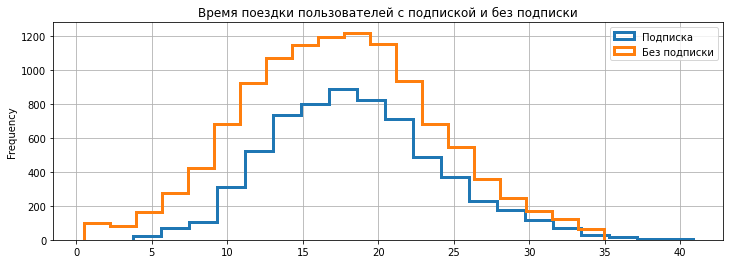

In [65]:
ax_1 = data_ultra['duration'].plot(
kind='hist',
histtype='step',
linewidth=3,
bins=20, 
figsize=(12,4),
legend=True,
label='Подписка',
title='Время поездки пользователей с подпиской и без подписки');

data_non_ultra['duration'].plot(
kind='hist',
histtype = 'step',
linewidth=3,
bins=20,
grid=True,
legend=True,
label='Без подписки',
ax=ax_1);

Из полученной гистограммы мы видим, что распределение по времени поездок у пользователей с подпиской и пользователей без подписки в целом одинаковое, среднее время поездки для обеих групп составляет примерно **18 минут**, но пользователи с подпиской ездят как минимум **4 минуты**, в то время как у пользователей без подписки есть поездки длительностью даже меньше минуты. Это связано с тем, что среди пользователей без подписки есть те, кто пробует поездки на электросамокатах впервые, и, возможно, этот опыт не всегда удачный. Стоит подумать, как можно сделать первый опыт поездки на самокате более комфортным. Например, размещение на самокате инструкций по безопасному катанию для новичков или распространение обучающих видео. Также можно заметить, что длительность поездок пользователей без подписки состовляет не более **35 минут**, в то время как у пользователей с подпиской есть поездки даже дольше **40 минут**, хотя эта доля незначительная и является по сути, выбросом. Однако, это говорит нам о том, что возможно есть люди, которые рассматривают самокаты, как полноценное средство передвижения, что является для нас потенциальной точкой роста.

#### Расстояние.

In [66]:
data_ultra['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

In [67]:
data_non_ultra['distance'].describe()

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

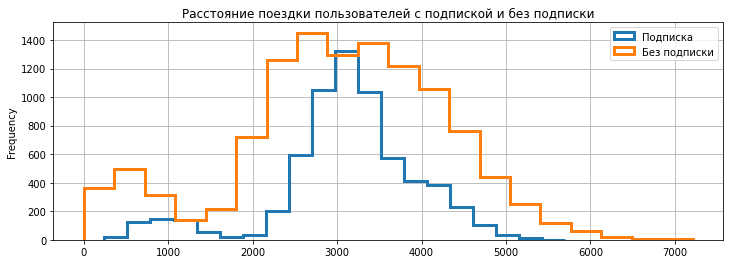

In [68]:
ax_2 = data_ultra['distance'].plot(
kind='hist',
histtype='step',
linewidth=3,
bins=20, 
figsize=(12,4),
legend=True,
label='Подписка',
title='Расстояние поездки пользователей с подпиской и без подписки');

data_non_ultra['distance'].plot(
kind='hist',
histtype = 'step',
linewidth=3,
bins=20,
grid=True,
legend=True,
label='Без подписки',
ax=ax_2);

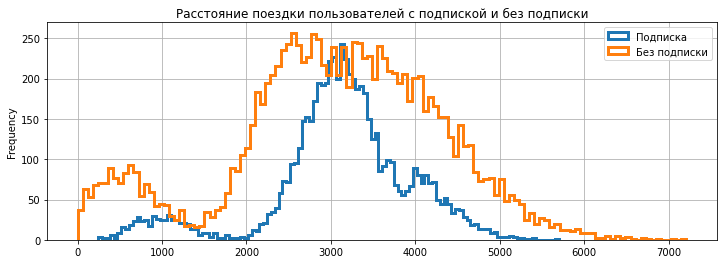

In [69]:
ax_2 = data_ultra['distance'].plot(
kind='hist',
histtype='step',
linewidth=3,
bins=120, 
figsize=(12,4),
legend=True,
label='Подписка',
title='Расстояние поездки пользователей с подпиской и без подписки');

data_non_ultra['distance'].plot(
kind='hist',
histtype = 'step',
linewidth=3,
bins=120,
grid=True,
legend=True,
label='Без подписки',
ax=ax_2);

На этапе объединения данных нами был сформирован единый датафрейм, в котором хранится информация об id пользователя, его имени, возрасте, городе, наличии/отсутствии подписки, а также сведения о расстоянии и длительности его поездок, дате совершения поездок и порядковом номере месяца, когда была совершена поездка. Также были созданы два датафрейма с информацией о пользователях с подпиской и без подписки. Проведена проверка, в результате которой установлено, что объединение данных в единый датафрейм и последующее его разделение по параметру наличия подписки не привело к потере строк или возникновению пропусков.

Также сформированы гистограммы, отображающие информацию о расстоянии и продолжительности поездок.

Из полученной гистограммы  с информацией о продолжительности поездок мы видим, что распределение по времени поездок у пользователей с подпиской и пользователей без подписки в целом одинаковое, среднее время поездки для обеих групп составляет примерно **18 минут**, но пользователи с подпиской ездят как минимум **4 минуты**, в то время как у пользователей без подписки есть поездки длительностью даже меньше минуты. Это связано с тем, что среди пользователей без подписки есть те, кто пробует поездки на электросамокатах впервые, и, возможно, этот опыт не всегда удачный. Стоит подумать, как можно сделать первый опыт поездки на самокате более комфортным. Например, размещение на самокате инструкций по безопасному катанию для новичков или распространение обучающих видео. Также можно заметить, что длительность поездок пользователей без подписки состовляет не более **35 минут**, в то время как у пользователей с подпиской есть поездки даже дольше **40 минут**, хотя эта доля незначительная и является по сути, выбросом. Однако, это говорит нам о том, что возможно есть люди, которые рассматривают самокаты, как полноценное средство передвижения, что является для нас потенциальной точкой роста.

Распределение среднего расстояния пользователей с подпиской и без подписки в целом похоже. Для обеих групп характерен провал по количеству поездок на расстояние около **2000 метров**. Также для пользователей без подписки характерны короткие поездки **не более 500 метров**, это связано с пробными поездками. Также для обеих групп наиболее распространенное расстояние поездки - это **3000 метров**. У группы людей без подписки также присутствуют выбросы на **6000 метров** и даже на **7000 метров**.

## Шаг 5. Подсчёт выручки
<a id='revenue'></a>

### 5.1 Создание агрегированного датафрейма.

In [70]:
data_sub = data_sub.set_index('subscription_type')

In [71]:
data_new_total = data_total.join(data_sub, on='subscription_type')
data_new_total

,user_id,name,age,city,subscription_type,distance,duration,date,ride_month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


### 5.2 Расчет помесячной выручки.

In [72]:
data_new_total['duration'] = np.ceil(data_new_total['duration'])


In [73]:
data_revenue = data_new_total.pivot_table(
    index=['user_id','ride_month'], 
    aggfunc={'distance':'sum', 
             'duration':'sum', 
             'ride_month':'count',
             'minute_price':'mean',
             'start_ride_price':'mean',
             'subscription_fee':'mean'} 
    )
data_revenue

distance  duration  minute_price  ride_month  \
user_id ride_month                                                     
1       1            7027.511294      42.0             6           2   
        4             754.159807       7.0             6           1   
        8            6723.470560      46.0             6           2   
        10           5809.911100      32.0             6           2   
        11           7003.499363      56.0             6           3   
...                          ...       ...           ...         ...   
1534    6            3409.468534      26.0             8           2   
        8            7622.453034      48.0             8           2   
        9            4928.173852      23.0             8           1   
        11          13350.015305      78.0             8           4   
        12           2371.711192      16.0             8           1   

                    start_ride_price  subscription_fee  
user_id ride_month                                      
1       1                          0               199  
        4                          0               199  
        8                          0               199  
        10                         0               199  
        11                         0               199  
...                              ...               ...  
1534    6                         50                 0  
        8                         50                 0  
        9                         50                 0  
        11                        50                 0  
        12                        50                 0  

[11331 rows x 6 columns]

In [74]:
data_revenue.isna().sum()

distance            0
duration            0
minute_price        0
ride_month          0
start_ride_price    0
subscription_fee    0
dtype: int64

In [75]:
data_revenue['revenue'] = data_revenue['minute_price']*data_revenue['duration']+data_revenue['start_ride_price']*data_revenue['ride_month']+data_revenue['subscription_fee']
data_revenue

distance  duration  minute_price  ride_month  \
user_id ride_month                                                     
1       1            7027.511294      42.0             6           2   
        4             754.159807       7.0             6           1   
        8            6723.470560      46.0             6           2   
        10           5809.911100      32.0             6           2   
        11           7003.499363      56.0             6           3   
...                          ...       ...           ...         ...   
1534    6            3409.468534      26.0             8           2   
        8            7622.453034      48.0             8           2   
        9            4928.173852      23.0             8           1   
        11          13350.015305      78.0             8           4   
        12           2371.711192      16.0             8           1   

                    start_ride_price  subscription_fee  revenue  
user_id ride_month                                               
1       1                          0               199    451.0  
        4                          0               199    241.0  
        8                          0               199    475.0  
        10                         0               199    391.0  
        11                         0               199    535.0  
...                              ...               ...      ...  
1534    6                         50                 0    308.0  
        8                         50                 0    484.0  
        9                         50                 0    234.0  
        11                        50                 0    824.0  
        12                        50                 0    178.0  

[11331 rows x 7 columns]

На этапе подсчета выручки нами были добавлены сведения о цене минут, старта поездки и ежемесячном платеже для всех пользователей (как с подпиской, так и без нее), а также длительность поездок округлена до минут в большую сторону для корректного расчета выручки.

На основе имеющейся информации нами была расчитана ежемесячная выручка для каждого пользователя.

In [76]:
data_revenue['revenue'].sum()

3878641.0

## Шаг 6. Проверка гипотез
<a id='check'></a>

### 6.1 Тратят ли пользователи с подпиской больше времени на поездки?

Возьмем за нулевую гипотезу следующее утверждение: Пользователи с подпиской тратят столько же времени на поездки, сколько и пользователи без подписки.

Альтернативной гипотезой будет: Пользователи с подпиской тратят больше времени на поездки.

Размер датафреймов позволяет нам работать со всей генеральной совокупностью.

In [77]:
non_ultra_mean_duration = data_non_ultra['duration'].mean().round(2)
non_ultra_mean_duration

17.39

In [78]:
alpha = 0.05

results = st.ttest_ind(data_ultra['duration'], data_non_ultra['duration'], alternative='greater' )

print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Нулевая гипотеза отвергается.')
else:
    print('Нельзя отвергнуть нулевую гипотезу.')

p-значение: 1.2804098316645618e-34
Нулевая гипотеза отвергается.


Нулевая гипотеза не подтвердилась. Пользователи с подпиской больше времени проводят, используя самокаты. Это выгодно для бизнеса, так как каждая минута оплачивается, также с учетом того, что пользователи с подпиской платят меньше за каждую минуту, можно предположить, что они с большей вероятностью не прерывают аренду, когда не пользуются самокатом, например, если им нужно дождаться друга, а потом поехать дальше.

### 6.2 Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 

Возьмем за нулевую гипотезу следующее утверждение: Пользователи с подпиской в среднем проезжают 3130 метров.

Альтернативной гипотезой будет: Пользователи с подпиской проезжают большего оптимального расстояния в 3130 метров.


In [79]:
check = 3130
alpha = 0.05

results = st.ttest_1samp(data_ultra['distance'], check, alternative='greater')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Нулевая гипотеза отвергается.')
else:
    print('Нет оснований отвергнуть нулевую гипотезу.')

p-значение: 0.9195368847849785
Нет оснований отвергнуть нулевую гипотезу.


Нет оснований отвергнуть нулевую гипотезу о том, что пользователи с подпиской проезжают в среднем не более 3130 метров. В таком случае износ самокатов происходит наиболее оптимально, однако это значит, что и время аренды ограничивается. Стоит подумать над тем, как добиться увеличения времени аренды при сохранении расстояния поездки, например ввести режим ожидания: когда самокат не двигается, то каждая минута стоит в два раза дешевле, чем при движении.

### 6.3 Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

Возьмем за нулевую гипотезу следующее утверждение: Помесячная выручка от пользователей с подпиской равна выручке от пользователей без подписки.

Альтернативной гипотезой будет: Помесячная выручка от пользователей с подпиской больше помесячной выручки пользователей без подписки.


In [80]:
alpha=0.05

results = st.ttest_ind(data_revenue[data_revenue['subscription_fee'] == 199]['revenue'], data_revenue[data_revenue['subscription_fee'] == 0]['revenue'], alternative='greater')
print('p-значение равно:', results.pvalue)
if results.pvalue < alpha:
    print('Нулевая гипотеза отвергается.')
else:
    print('Нулевая гипотеза не отвергается.')

p-значение равно: 1.8850394384715216e-31
Нулевая гипотеза отвергается.


Нулевая гипотеза отвергается. Следовательно, выручка от пользователей с подпиской больше чем от пользователей без подписки. Значит целесообразно привлекать пользователей без подписки к её покупке. Например, рассылать им промокоды на первый бесплатный месяц.

### 6.4 Тест для оценки изменений количества обращений в сервисную службу.

Техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось.

Так как оценивается один и тот же объект - обращения в техническую поддержку, то выборки по обращениям до и после обновления будут зависимыми. В таком случае необходимо применить тест равенства среднего генеральной совокупности для зависимых (парных) выборок **(метод scipy.stats.ttest_rel())**. 

Для данной задачи должна быть разработа следующая односторонняя гипотеза:

Нулевая гипотеза: количество обращений до и после обновления серверов равно.

Альтернативная гипотеза: количество обращений после обновления серверов снизилось.

## Шаг 7. Распределения

### 7.1

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

/opt/conda/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


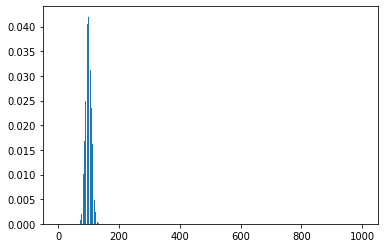

In [81]:
distr = []
n = 1000
k = 100
p = 0.1

for k in range(0, n + 1):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)

plt.bar(range(0, n + 1), distr);

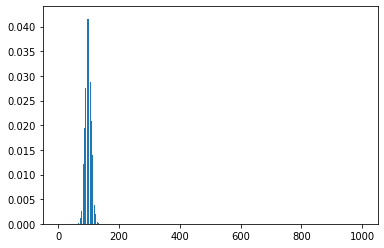

In [82]:
distr = []
n = 1000
k = 100
p = 0.1

for k in range(1, n + 2):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)

plt.bar(range(0, n + 1), distr);

При n = 1000, мат.ожидание будет равняться 100. Возьмем такой n за стартовое значение.

In [83]:
mu = n*p
sigma = sqrt(n*p*(1-p)) 

distr_norm = st.norm(mu,sigma)
x = 100

result = distr_norm.cdf(x)
result

0.5

n = 1000 дает вероятность 50% того, что случайная величина будет меньше 100. Однако нам требуется вероятность, что план не будет выполнен равная 5%. Попробуем увеличить количество n.

In [84]:
n = 1170

In [85]:
mu = n*p
sigma = sqrt(n*p*(1-p)) 

distr_norm = st.norm(mu,sigma)
x = 100

result = distr_norm.cdf(x)
result.round(3)

0.049

При раздаче 1170 промокодов мы получим нужную нам вероятность невыполнения плана.

### 7.2

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

In [86]:
from scipy import stats as st

n=1000000 # количество экспериментов
p=0.4 # вероятность успеха
k=399500 # количество успешных экспериментов

# математическое ожидание
mu = 400000
# стандартное отклонение
sigma = 490

# задаём нормальное распределение с математическим ожиданием 1000 
# и стандартным отклонением 100
distr = st.norm(mu, sigma) 

# значение, для которого хотим найти вероятность
x = 399500


# Проверим качество аппроксимации
if (mu - (3 * sigma) >= 0) and ((mu + (3 * sigma) <= n)):
    print('Условие выполняется')
else:
    print('Условие не выполняется')

Условие выполняется


In [87]:
result = distr.cdf(399500) # расчет вероятности, что будет открыто менее 399500 уведомлений.
print(result)

0.15376746196860203


Вероятность того, что уведомление откроют не более 399500 пользователей составляет 15.3%. В целом с большой долей вероятности (около 85%) можно считать, что более 600000 человек откроют рассылку, если цель была такой, то увеличивать количество получателей не требуется. 

In [88]:
n=1000000 # количество экспериментов
p=0.4 # вероятность успеха
k=399500 # количество успешных экспериментов

# математическое ожидание
mu = 400000
# стандартное отклонение
sigma = 490

# задаём нормальное распределение с математическим ожиданием 1000 
# и стандартным отклонением 100
distr = st.norm(mu, sigma) 

# значение, для которого хотим найти вероятность
x = 399500

result = distr.cdf(600_000) # расчет вероятности, что будет открыто менее 399500 уведомлений.
print(result)

1.0


## ОБЩИЙ ВЫВОД

Нами проводился анализ данных сервиса по аренде самокатов. В нашем распоряжении были следующие данные:

**Датафрейм 1:**
- `user_id` - уникальный идентификатор пользователя
- `name` - имя пользователя
- `age` - возраст
- `city` - город
- `subscription_type` - тип подписки (free, ultra)

**Датафрейм 2:**
- `user_id` - уникальный идентификатор пользователя
- `distance` -	расстояние, которое пользователь проехал в текущей сессии (в метрах)
- `duration` -	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- `date` -	дата совершения поездки *(в наличии данные за 2021 год)*

**Датафрейм 3:**
- `subscription_type`	тип подписки
- `minute_price` -	стоимость одной минуты поездки по данной подписке
- `start_ride_price` -	стоимость начала поездки
- `subscription_fee` -	стоимость ежемесячного платежа

[После первого рассмотрения данных стоит выделить основные моменты:](#download)

1) В датафрейме с информацией о пользователях 1565 строк, то есть дана информация о 1565 пользователях, однако, необходимо проверить датафрейм на дубликаты. В этом датафрейме для данных указаны подходящие типы данных, дополнительных действий с ним не требуется.

2) В датафрейме с информацией о поездках 18068 строк. Эти данные также требуется проверить на наличие дубликатов. Изначально столбец, содержащий дату поездки был представлен в формат object, однако на этапе загрузки данных мы перевели его в корректный формат даты. Также информация о длительности поездки и расстоянии даны с точностью 6 знаков после запятой, такая точность в целом излишне, но пока оставим данные в исходном виде и округлим их в случае необходимости.

3) Датафрейм с информацией о подписках содержит всего 2 строки. Одна строка с информацией о цене старта, цене за минуту и плате за подписку для владельцев подписки, а вторая - с аналогичной информацией для пользователей без подписки.

**[На этапе предобработки данных проведены следующие действия:](#preproc)**

* В датафрейм `data_rides` добавлен столбец `ride_month`, содержащий информацию о порядковом номере месяца, в котором была совершена поездка
* Проведена проверка на наличие пропусков. Пропуски отсутствуют.
* Проведена проверка на наличие дубликатов. Обнаружены и удалены 31 дубликат в столбце `data_users`

**[На этапе исследовательского анализа данных нами проведены следующие действия:](#data_analysis)**

* Проведена оценка встречаемости городов, в которых брали в аренду самокаты. 
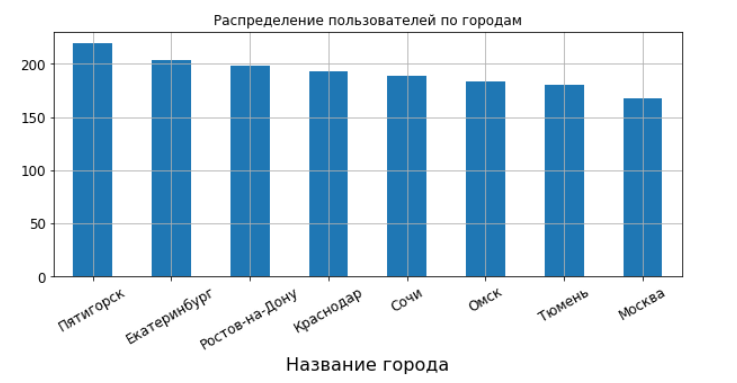
Всего 8 городов. Больше всего пользователей в Пятигорске - **219**, а меньше всего в Москве - **168**. В процентах это около 2.5% разницы. Однако самый непопулярный город - Москва, имеющий огромный потенциал для развития. Стоит обратить внимание на этот город и провести рекламную акцию для москвичей, а также подумать над расширением бизнеса там.
* Определено соотношение пользователей с подпиской и без подписки. 
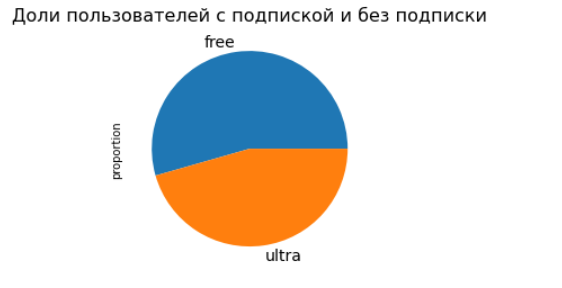
Соотношение равно 54.4% пользователей без подписки и 46.6% пользователей с подпиской.
* Определен возраст пользователей. 
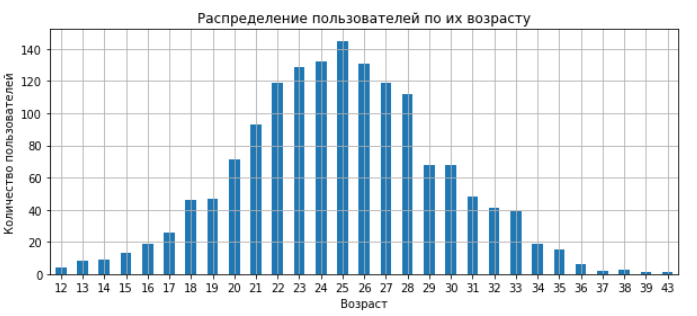
Сервисом пользуются люди **от 12 до 43 лет**, также можно обратить внимание, что возраст распределяется нормально, что говорит о хорошем качестве данных. Значения меньше 13 и больше 37 лет признаны выбросами, однако оставлены для дальнейшего исследования. Пик приходится на 25 лет. Следует разрабатывать рекламные акции, а также тарифы с расчетом на целевую аудиторию в диапазоне 20 - 30 лет. Например: скидки для студентов, размещение парковок самокатов около университетов и так далее.
* Оценено расстояние, которое пользователи преодолевают за поездку. 
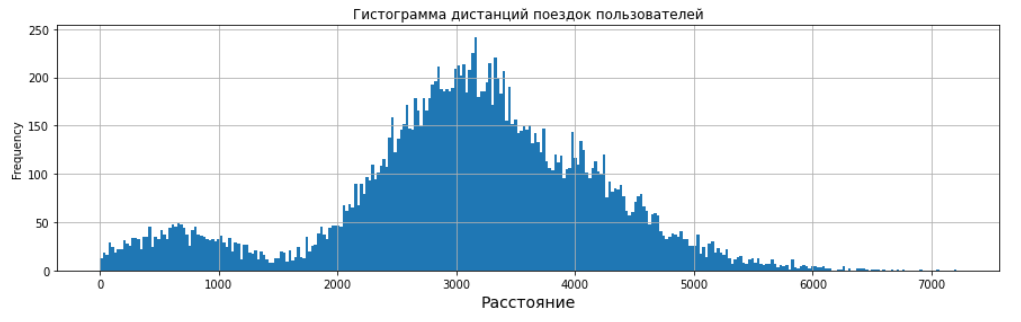
Среднее расстояние равно **3071 метр** за поездку. Большая часть поездок имеют расстояние **от 2000 до 5000 метров**. поездки **короче 110 и длиннее 5750 метров** признаны выбросами. На графике заметны два пика: большой в районе **3100 метров** и малый в районе **700 метров**. Можно предположить, что пик в районе 3100 метров вызван тем, что это расстояние, для преодоления которого люди с наибольшей вероятностью воспользуются арендой самоката, так как меньшее расстояние можно пройти пешком, а чтобы преодолеть большее расстояние, целесообразнее уже заказать такси/поехать на общественном транспорте. Исходя из этого предположения стоит рассмтотреть возможность размещения самокатов там, где люди с большей вероятностью возьмут самокат не с целью добраться до какой-либо точки, а чтобы просто покататься, например у входов в парки. Пик в районе 700 метров - это скорее всего первые пробные поездки. В таком случае требуется сделать эти пробные метры наиболее привлекательными, например первые 1000 метров будут стоить дешевле или вообще бесплатными.
* Оценена продолжительность поездок. 
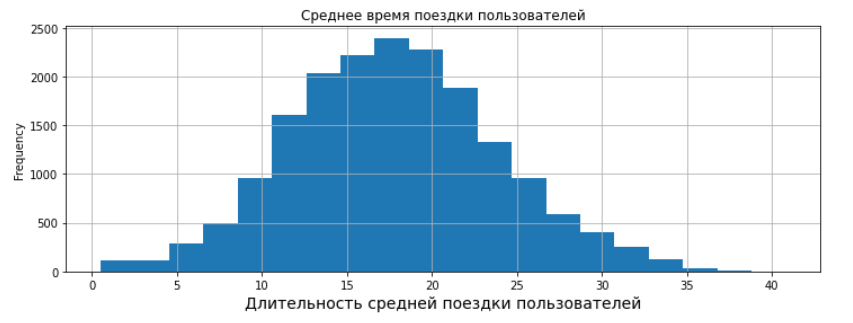
Средняя продолжительность поездки составила около **18 минут**. Длительность поездок не превышает **40 минут**. Определено, что поездки **короче 1.5 и длиннее 34 минут** являются выбросами. Стоит рассмотреть возможность ограничения скорости самокатов в пешеходных зонах, парках и например в радиусе 300 метров от школ, детских садов, с одной стороны это повысит безопасность, а с другой увеличит время, за которое человек сможет преодолеть необходимое емк расстояние, что повысит выручку.

**[На этапе объединения данных:](#join)** 

Нами сформирован единый датафрейм, в котором хранится информация об id пользователя, его имени, возрасте, городе, наличии/отсутствии подписки, а также сведения о расстоянии и длительности его поездок, дате совершения поездок и порядковом номере месяца, когда была совершена поездка. Также были созданы два датафрейма с информацией о пользователях с подпиской и без подписки. Проведена проверка, в результате которой установлено, что объединение данных в единый датафрейм и последующее его разделение по параметру наличия подписки не привело к потере строк или возникновению пропусков.

Также сформированы гистограммы, отображающие информацию о расстоянии и продолжительности поездок.
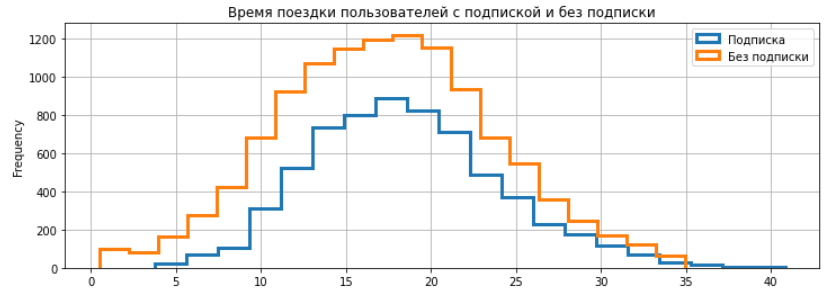

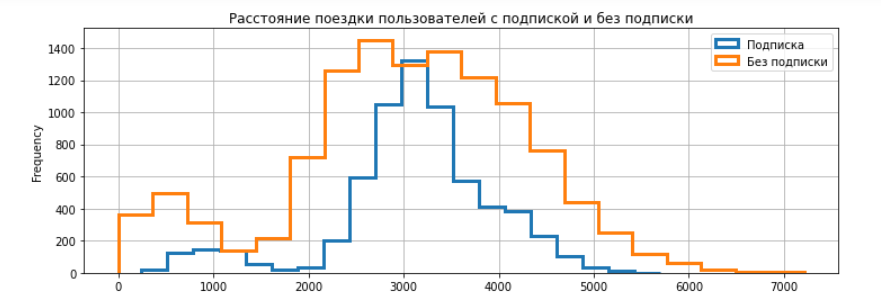

Из полученной гистограммы  с информацией о продолжительности поездок мы видим, что распределение по времени поездок у пользователей с подпиской и пользователей без подписки в целом одинаковое, среднее время поездки для обеих групп составляет примерно **18 минут**, но пользователи с подпиской ездят как минимум **4 минуты**, в то время как у пользователей без подписки есть поездки длительностью даже меньше минуты. Это связано с тем, что среди пользователей без подписки есть те, кто пробует поездки на электросамокатах впервые, и, возможно, этот опыт не всегда удачный. Стоит подумать, как можно сделать первый опыт поездки на самокате более комфортным. Например, размещение на самокате инструкций по безопасному катанию для новичков или распространение обучающих видео. Также можно заметить, что длительность поездок пользователей без подписки состовляет не более **35 минут**, в то время как у пользователей с подпиской есть поездки даже дольше **40 минут**, хотя эта доля незначительная и является по сути, выбросом. Однако, это говорит нам о том, что возможно есть люди, которые рассматривают самокаты, как полноценное средство передвижения, что является для нас потенциальной точкой роста.

Распределение среднего расстояния пользователей с подпиской и без подписки в целом похоже. Для обеих групп характерен провал по количеству поездок на расстояние около **2000 метров**. Также для пользователей без подписки характерны короткие поездки **не более 500 метров**, это связано с пробными поездками. Также для обеих групп наиболее распространенное расстояние поездки - это **3000 метров**. У группы людей без подписки также присутствуют выбросы на **6000 метров** и даже на **7000 метров**.

**[На этапе подсчета выручки](#revenue)** нами были добавлены сведения о цене минут, старта поездки и ежемесячном платеже для всех пользователей (как с подпиской, так и без нее), а также длительность поездок округлена до минут в большую сторону для корректного расчета выручки.

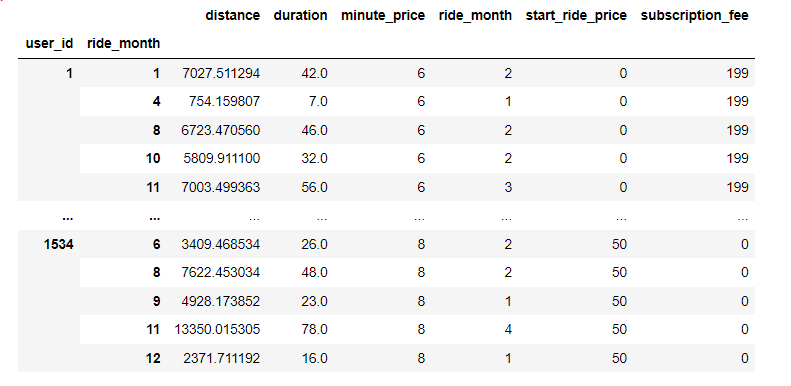

На основе имеющейся информации нами была расчитана ежемесячная выручка для каждого пользователя.

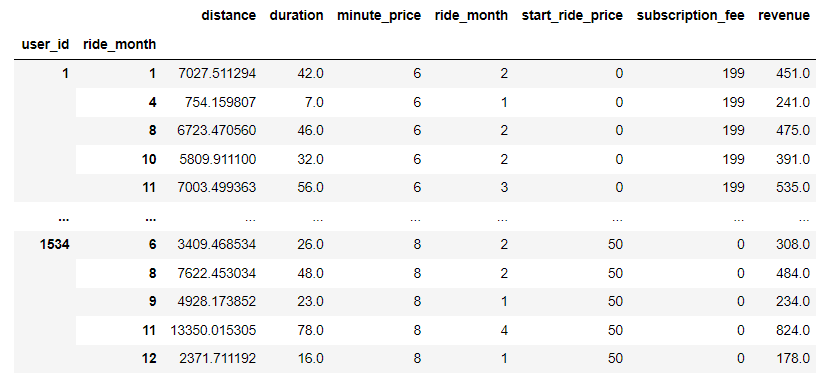

Суммарная выручка за 2021 год составила **3878641 рублей**.

На **[этапе проверки гпиотез](#check)** нами были проверены следующие гипотезы:

- *Тратят ли пользователи с подпиской больше времени на поездки?*. 

За нулевую гипотезу нами было принято, что пользователи с подпиской тратят столько же времени на поездки, сколько и пользователи без подписки. Альтернативной гипотезой являлось, что пользователи с подпиской тратят больше времени на поездки. По итогам проведенного тестирования нулевая гипотеза была опровергнута. Пользователи с подпиской больше времени проводят, используя самокаты. Это выгодно для бизнеса, так как каждая минута оплачивается, также с учетом того, что пользователи с подпиской платят меньше за каждую минуту, можно предположить, что они с большей вероятностью не прерывают аренду, когда не пользуются самокатом, например, если им нужно дождаться друга, а потом поехать дальше.

- *Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?*. 

За нулевую гипотезу было взято, что пользователи с подпиской в среднем проезжают 3130 метров. Альтернативной гипотезой было: Пользователи с подпиской проезжают больше оптимального с точки зрения износа самокатов расстояния в 3130 метров. По итогам тестирования нет оснований отвергнуть нулевую гипотезу о том, что пользователи с подпиской проезжают в среднем не более 3130 метров. В таком случае износ самокатов происходит наиболее оптимально, однако это значит, что и время аренды ограничивается. Стоит подумать над тем, как добиться увеличения времени аренды при сохранении расстояния поездки, например ввести режим ожидания: когда самокат не двигается, то каждая минута стоит в два раза дешевле, чем при движении.

- *Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?* 

Нулевой гипотезой являлось следующее утверждение: Помесячная выручка от пользователей с подпиской равна выручке от пользователей без подписки. Альтернативная гипотеза была: Помесячная выручка от пользователей с подпиской больше помесячной выручки пользователей без подписки. По итогам тестирования нулевая гипотеза была отвергнута, Нулевая гипотеза отвергается. Следовательно, выручка от пользователей с подпиской больше чем от пользователей без подписки. Значит целесообразно привлекать пользователей без подписки к её покупке. Например, рассылать им промокоды на первый бесплатный месяц.